In [26]:
# Import necessary packages
using SparseArrays
using StaticArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

include("Grid.jl")
include("Stokes.jl")

unpack (generic function with 1 method)

In [27]:
mutable struct Markers    
    x::Array{Float64,2}
    cell::Array{Int,2}
    rho::Array{Float64,1}
    eta::Array{Float64,1}
    nmark::Integer
    
    function Markers(grid::CartesianGrid; nmx::Integer=5,nmy::Integer=5)
        N = nmx*nmy*grid.nx*grid.ny
        mdx = grid.W/nmx/(grid.nx-1)
        mdy = grid.H/nmy/(grid.ny-1)
                
        x = Array{Float64,2}(undef,2,N)
        cell = Array{Int,2}(undef,2,N)
        rho = Array{Float64,1}(undef,N)
        eta = Array{Float64,1}(undef,N)
        
        k=1
        for i in 1:(grid.ny-1)
            for j in 1:(grid.nx-1)
                for ii in 1:nmy
                     for jj in 1:nmx
                        x[1,k] = mdx/2. + mdx*(jj-1) + mdx*nmx*(j-1)
                        x[2,k] = mdy/2. + mdy*(ii-1) + mdy*nmy*(i-1)
                        cell[1,k] = j
                        cell[2,k] = i
                        rho[k] = 0.0
                        k+=1
                    end
                end
            end
        end

        new(x,cell,rho,eta,k-1)
    end
end

In [71]:
function find_cell(x::Float64,gridx::Vector{Float64},nx::Int ; guess::Integer=nothing)
    # find the cell in the array gridx that contains the current marker
    # first, see whether the initial guess is correct.
    lower::Int = 1
    upper::Int = nx
    if guess != nothing && guess >= 1 && guess < nx
        if x >= gridx[guess] && x < gridx[guess+1]
            return guess            
        elseif guess < nx-1 && x>=gridx[guess+1] && x<gridx[guess+2]
            return guess+1
        elseif guess > 1 && x < gridx[guess] && x >= gridx[guess-1]
            return guess-1
        else
            if x>=gridx[guess+1]
                lower = guess
            else
                upper = guess+1
            end
        end
     end
    # locate cell using bisection on lower,upper
    while upper-lower > 1 
        midpoint::Int = lower + floor((upper-lower)/2)
        if x >= gridx[midpoint]
            lower = midpoint
        else
            upper = midpoint
        end
    end
    return lower
end

function find_cells!(markers::Markers,grid::CartesianGrid)
   for i in 1:markers.nmark
        markers.cell[1,i] = find_cell(markers.x[1,i] , grid.x, grid.nx, guess=markers.cell[1,i])
        markers.cell[2,i] = find_cell(markers.x[2,i] , grid.y, grid.ny, guess=markers.cell[2,i])
    end
end

function initial_density!(markers::Markers)
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        markers.rho[i] = mx >= 200e3 && mx <= 300e3 ? 3200. : 3300.
    end
end

function marker_to_basic_node(m::Markers,grid::CartesianGrid)
    weights = zeros(grid.ny,grid.nx)
    weighted_sum = zeros(grid.ny,grid.nx)
    # loop over the markers
    for i in 1:m.nmark
       # calculate weights for four surrounding basic nodes
         cellx::Int = m.cell[1,i]
         celly::Int = m.cell[2,i]
         wx = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
         wy = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
         #i,j
         weighted_sum[celly,cellx] += (1.0-wx)*(1.0-wy)*m.rho[i]
         weights[celly,cellx]      += (1.0-wx)*(1.0-wy)
         #i+1,j
         weighted_sum[celly+1,cellx] += (1.0-wx)*(wy)*m.rho[i]
         weights[celly+1,cellx]      += (1.0-wx)*(wy)
         #i,j+1
         weighted_sum[celly,cellx+1] += (wx)*(1.0-wy)*m.rho[i]
         weights[celly,cellx+1]      += (wx)*(1.0-wy)
         #i+1,j+1
         weighted_sum[celly+1,cellx+1] += (wx)*(wy)*m.rho[i]
         weights[celly+1,cellx+1]      += (wx)*(wy)        
    end
    weighted_sum = weighted_sum ./ weights
    return weighted_sum
end

function basic_node_to_markers!(m::Markers,grid::CartesianGrid,field::Matrix)
    for i in 1:m.nmark
        cellx = m.cell[1,i]
        celly = m.cell[2,i]
        wx::Float64 = (m.x[1,i] - grid.x[cellx])/(grid.x[cellx+1]-grid.x[cellx]) # mdx/dx
        wy::Float64 = (m.x[2,i] - grid.y[celly])/(grid.y[celly+1]-grid.y[celly])
        
        m.rho[i] = (1.0-wx)*(1.0-wy)*field[celly,cellx] +
            + (wx)*(1.0-wy)*field[celly,cellx+1] +
            + (1.0-wx)*(wy)*field[celly+1,cellx] +
            + (wx)*(wy)*field[celly+1,cellx+1]
    end
end

function velocity_to_centers(grid::CartesianGrid,vx::Matrix,vy::Matrix)
     vxc = zeros(grid.ny+1,grid.nx+1);
     vyc = zeros(grid.ny+1,grid.nx+1);
     # cell centers are offset in (-) direction from basic nodes.
     for i in 1:grid.ny+1        
        for j in 1:grid.nx+1
            vxm = j==1 ? 0.0 : vx[i,j-1]
            vxp = vx[i,j]
            vym = i==1 ? 0.0 : vy[i-1,j]
            vyp = vy[i,j]
            vxc[i,j] = 0.5*(vxp+vxm)
            vyc[i,j] = 0.5*(vyp+vym)            
        end
    end
    return vxc,vyc
end

function velocity_to_points(x::Matrix,cell::Matrix,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # x should be 2-by-N
    N = size(x,2)
    mvx = Array{Float64,1}(undef,N) # velocities at specified locations
    mvy = Array{Float64,1}(undef,N) 
    for i in 1:N
        cellx::Int = x[1,i] < grid.xc[cell[1,i]+1] ? cell[1,i] : cell[1,i] + 1
        celly::Int = x[2,i] < grid.yc[cell[2,i]+1] ? cell[2,i] : cell[2,i] + 1
        mdx::Float64 = (x[1,i] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy::Float64 = (x[2,i] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function velocity_to_markers(m::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix)
    # This function expects the velocities to be defined at the cell centers. vxc and vyc should each have
    # an 'extra' column and row corresponding to the ghost degrees of freedom that are needed to interpolate
    # velocities along the bottom and left of the domain.
    mvx = Array{Float64,1}(undef,m.nmark) # velocities at marker locations
    mvy = Array{Float64,1}(undef,m.nmark) 
    # interpolate x-velocity
    for i in 1:m.nmark
        cellx::Int = m.x[1,i] < grid.xc[m.cell[1,i]+1] ? m.cell[1,i] : m.cell[1,i] + 1
        celly::Int = m.x[2,i] < grid.yc[m.cell[2,i]+1] ? m.cell[2,i] : m.cell[2,i] + 1
        mdx::Float64 = (m.x[1,i] - grid.xc[cellx])/(grid.xc[cellx+1]-grid.xc[cellx])
        mdy::Float64 = (m.x[2,i] - grid.yc[celly])/(grid.yc[celly+1]-grid.yc[celly])
        mvx[i] = (1-mdx)*(1-mdy)*vxc[celly,cellx] +
            + (mdx)*(1-mdy)*vxc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vxc[celly+1,cellx] +
            + (mdx)*(mdy)*vxc[celly+1,cellx+1]
        mvy[i] = (1-mdx)*(1-mdy)*vyc[celly,cellx] +
            + (mdx)*(1-mdy)*vyc[celly,cellx+1] +
            + (1-mdx)*(mdy)*vyc[celly+1,cellx] +
            + (mdx)*(mdy)*vyc[celly+1,cellx+1]
    end    
    return mvx,mvy
end

function move_markers!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # compute velocities for each marker
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # determine the maximal timestep
    vxmax = maximum(abs.(mvx))
    vymax = maximum(abs.(mvy))
    for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end    
    find_cells!(markers,grid)
    return dt
end

function move_markers_rk2!(markers::Markers,grid::CartesianGrid,vxc::Matrix,vyc::Matrix,dt::Float64)
    # compute velocities for each marker at current position
    mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
    # compute marker location at xA, xB
    xB = Array{Float64,2}(undef,2,markers.nmark)
    for i in 1:markers.nmark
        xB[1,i] = markers.x[1,i] + dt/2*mvx[i]
        xB[2,i] = markers.x[2,i] + dt/2*mvy[i]
    end
    # re-locate markers
    cell = copy(markers.cell)
    for i in 1:markers.nmark
        cell[1,i] = find_cell(xB[1,i], grid.x, grid.nx, guess=cell[1,i])
        cell[2,i] = find_cell(xB[2,i], grid.y, grid.ny, guess=cell[2,i])
    end
    # compute velocity at xB
    mvx,mvy = velocity_to_points(xB,cell,grid,vxc,vyc)
    # move markers according to mvx,mvy
    
    for i in 1:markers.nmark
        markers.x[1,i] += dt*mvx[i]
        markers.x[2,i] += dt*mvy[i]
    end
    find_cells!(markers,grid)
end

function compute_timestep(grid::CartesianGrid,vxc::Matrix,vyc::Matrix;dtmax::Float64=Inf,cfl::Float64=0.5)
    for i in 2:grid.ny
        for j in 2:grid.nx
            dx = grid.x[j]-grid.x[j-1]
            dy = grid.y[i]-grid.y[i-1]
            dtmax = min( dtmax , cfl*dx/abs(vxc[i,j]) , cfl*dy/abs(vyc[i,j]) )                            
        end
    end
    return dtmax
end

compute_timestep (generic function with 1 method)

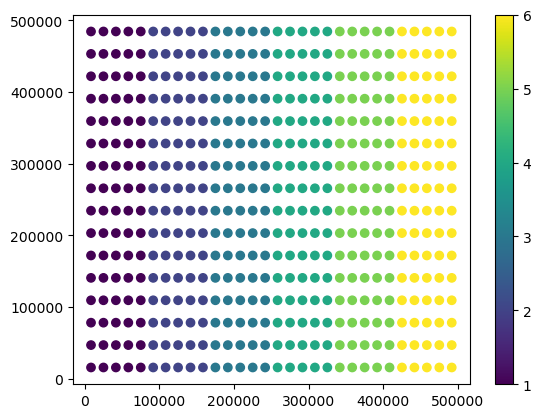

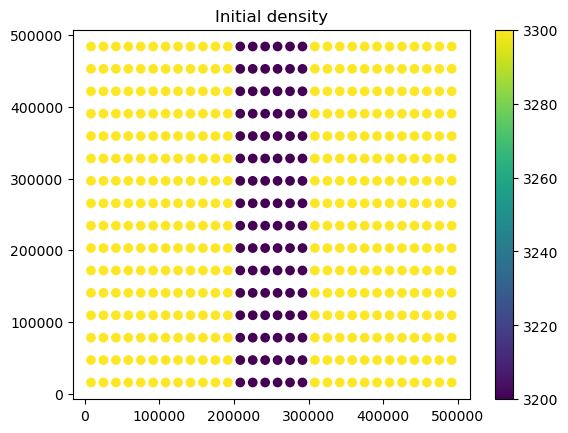

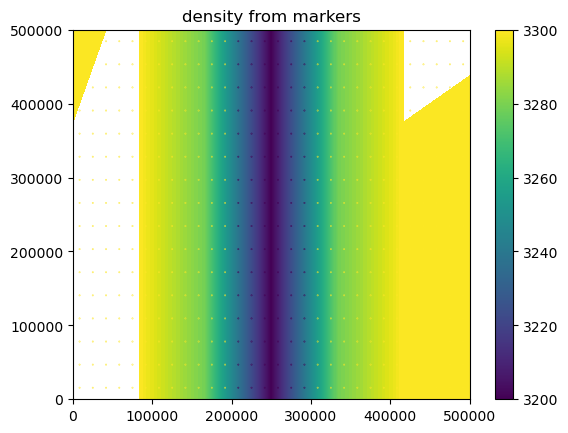

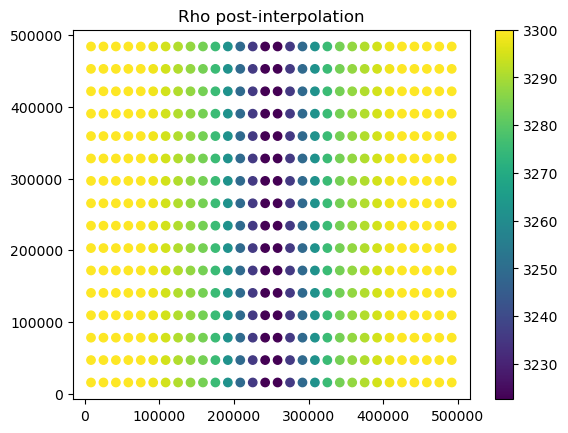

In [72]:
# Diagnostic tests on marker routines:
# Set up a grid and some markers
nx = 7
ny = 5
W = 5e5
H = 5e5
gy = -10.0
gx =  0.0
markx = 5
marky = 4
grid = CartesianGrid(W,H,nx,ny)
markers = Markers(grid;nmx=markx,nmy=marky)

mx = [markers.x[1,i] for i in 1:markers.nmark]
my = [markers.x[2,i] for i in 1:markers.nmark]
mcx = [markers.cell[1,i] for i in 1:markers.nmark]
mcy = [markers.cell[2,i] for i in 1:markers.nmark]

using PyPlot
figure()
scatter(mx,my,c=mcx)
colorbar()
show()

initial_density!(markers)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
title("Initial density")
colorbar()
show()


rho_node = marker_to_basic_node(markers,grid)

figure()
contourf(grid.x,grid.y,rho_node,100)
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho,s=0.1)
title("density from markers")
colorbar()
show()

basic_node_to_markers!(markers,grid,rho_node)

figure()
mrho = [markers.rho[i] for i in 1:markers.nmark]
scatter(mx,my,c=mrho)
title("Rho post-interpolation")
colorbar()
show()

In [73]:
markers.x

2×700 Matrix{Float64}:
  8333.33  25000.0  41666.7  58333.3  75000.0  …  0.0  0.0  0.0  0.0  0.0
 15625.0   15625.0  15625.0  15625.0  15625.0     0.0  0.0  0.0  0.0  0.0

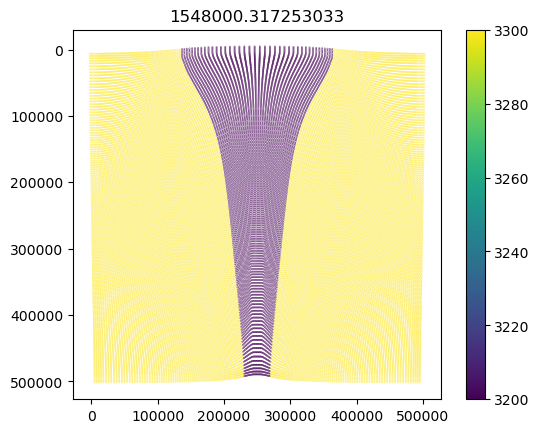

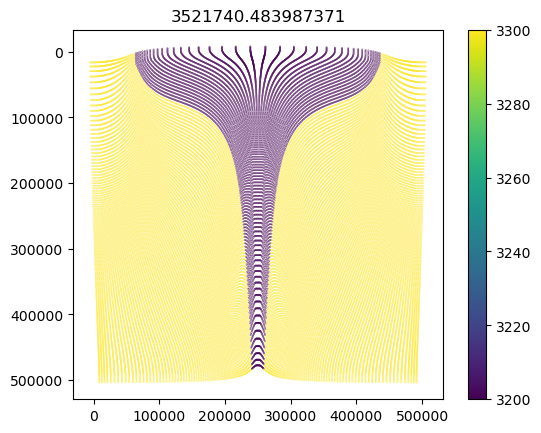

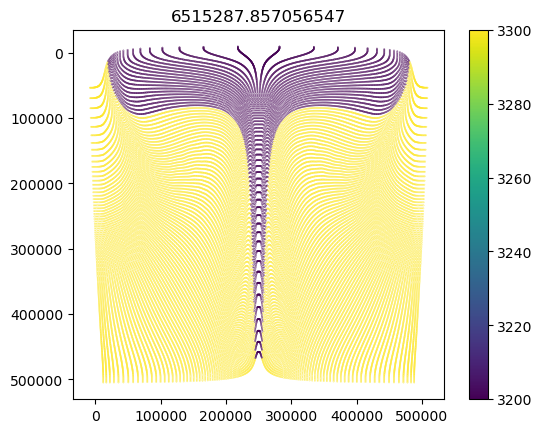

Creating Markers...
  0.000596 seconds (12 allocations: 2.019 MiB)


In [76]:
# Set up the grid
nx = 21
ny = 21
W = 5e5
H = 5e5
gy = 10.0
gx =  0.0
markx = 10
marky = 10
plot_interval = 10
dtmax = 1e6*3.15e7

grid = CartesianGrid(W,H,nx,ny)
println("Creating Markers...")
@time markers = Markers(grid ; nmx=markx,nmy=marky)


function plots(markers::Markers,grid::CartesianGrid,rho::Matrix,time)
    @views mx = markers.x[:,1:markers.nmark]
    @views mrho = markers.rho[1:markers.nmark]
    figure()
    #pcolor(grid.x,grid.y,rho)
    scatter(mx[1,:],mx[2,:],c=mrho,s=0.05)
    colorbar()
    gca().invert_yaxis()
    title(time)
    gca().set_aspect("equal")
    show()
end

# Initial conditions
initial_density!(markers)

time = 0.0
for itime in 1:31
    # density  markers -> nodes
    rho = marker_to_basic_node(markers,grid)
    eta_s = 1e21 .* ones(grid.ny,grid.nx)
    eta_n = 1e21 .* ones(grid.ny,grid.nx)

    # rho,eta_s,eta_n = initial_conditions(grid)
    bc = BoundaryConditions(0,0,0,0)
    L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
    solution = L\R
    vx,vy,P = unpack(solution,grid;ghost=true)
    vxc,vyc = velocity_to_centers(grid,vx,vy)
    dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)
    move_markers_rk2!(markers,grid,vxc,vyc,dt)
    #dt = move_markers!(markers,grid,vxc,vyc;dtmax=dt)
    if itime % plot_interval == 0
        plots(markers,grid,rho,time/3.15e7)
    end
    time += dt
end

In [48]:
mx = [markers.x[1] for i in 1:markers.nmark]
my = [markers.x[2] for i in 1:markers.nmark]
mrho = [markers.m[i].rho for i in 1:markers.nmark]
figure()
scatter(mx,my,c=mrho,s=0.01)
gca().invert_yaxis()
colorbar()
title(time/3.15e7)
show()
    rho = marker_to_basic_node(markers,grid)
figure()
pcolor(rho)
colorbar()
title(time/3.15e7)
gca().invert_yaxis()

show()

LoadError: type Markers has no field m

In [52]:
using Profile
rho = marker_to_basic_node(markers,grid)
eta_s = 1e21 .* ones(grid.ny,grid.nx)
eta_n = 1e21 .* ones(grid.ny,grid.nx)

# rho,eta_s,eta_n = initial_conditions(grid)
bc = BoundaryConditions(0,0,0,0)
L,R = form_stokes(grid,eta_s,eta_n,rho,bc,gx,gy)
solution = L\R

vx,vy,P = unpack(solution,grid;ghost=true)
vxc,vyc = velocity_to_centers(grid,vx,vy)

@time vxc,vyc = velocity_to_centers(grid,vx,vy)
@time mvx,mvy = velocity_to_markers(markers,grid,vxc,vyc)
@time move_markers!(markers,grid,vxc,vyc)

  0.000014 seconds (5 allocations: 7.969 KiB)
  0.073895 seconds (838.99 k allocations: 14.023 MiB)
  0.132933 seconds (1.72 M allocations: 29.251 MiB, 3.24% gc time)


1.918758547666858e14

In [75]:

maximum(abs.(mvx))

1.1759302234958616e-9

In [11]:
print(grid.y)
print("\n")
print(grid.yc)

[0.0, 10204.08163265306, 20408.16326530612, 30612.244897959183, 40816.32653061224, 51020.40816326531, 61224.489795918365, 71428.57142857142, 81632.65306122448, 91836.73469387756, 102040.81632653062, 112244.89795918367, 122448.97959183673, 132653.0612244898, 142857.14285714284, 153061.22448979592, 163265.30612244896, 173469.38775510204, 183673.46938775512, 193877.55102040817, 204081.63265306124, 214285.71428571426, 224489.79591836734, 234693.8775510204, 244897.95918367346, 255102.04081632654, 265306.1224489796, 275510.2040816326, 285714.2857142857, 295918.36734693876, 306122.44897959183, 316326.5306122449, 326530.61224489793, 336734.693877551, 346938.7755102041, 357142.85714285716, 367346.93877551024, 377551.02040816325, 387755.10204081633, 397959.1836734694, 408163.2653061225, 418367.3469387755, 428571.4285714285, 438775.5102040816, 448979.5918367347, 459183.67346938775, 469387.7551020408, 479591.83673469385, 489795.9183673469, 500000.0]
[-5102.040816326531, 5102.040816326531, 15306.12

In [78]:
    dt = max(1,2)

2

In [34]:
@time mx = [m.x for m in markers.m]


LoadError: UndefRefError: access to undefined reference